In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, Attention, LayerNormalization, Dense
from sklearn import tree
from tensorflow.keras import models, layers
import warnings

from keras.metrics import Recall
from keras.metrics import Accuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import keras.models
from keras.models import Sequential 

In [2]:
df = pd.read_csv('clean_sql_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148325 entries, 0 to 148324
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   148325 non-null  object
 1   Label   148325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
df.dropna(inplace=True)

In [5]:
X=df['Query']
y=df['Label']

In [6]:
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

611635

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
max_words = 611635
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [9]:
from keras.models import Sequential
from keras.layers import InputLayer, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Reshape

model = Sequential(name="CNN")
model.add(InputLayer(input_shape=(max_len,)))
model.add(Embedding(max_words,100,input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(Reshape((32, -1)))
model.add(LSTM(64))
model.add(layers.Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation = 'relu'))
model.add(Dense(1,activation="sigmoid"))
model.summary()



Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          61163500  
                                                                 
 conv1d (Conv1D)             (None, 147, 32)           12832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 73, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           32896 

In [10]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [11]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history = model.fit(sequences_matrix,y_train, batch_size=512, epochs=20,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/20


186/186 [==============================] - 116s 596ms/step - loss: 0.1546 - accuracy: 0.9327 - val_loss: 0.0484 - val_accuracy: 0.9886
Epoch 2/20
186/186 [==============================] - 110s 590ms/step - loss: 0.0334 - accuracy: 0.9923 - val_loss: 0.0444 - val_accuracy: 0.9879
Epoch 3/20
186/186 [==============================] - 110s 592ms/step - loss: 0.0200 - accuracy: 0.9951 - val_loss: 0.0512 - val_accuracy: 0.9876
Epoch 4/20
186/186 [==============================] - 109s 586ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0588 - val_accuracy: 0.9874
Epoch 5/20
186/186 [==============================] - 208s 1s/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0636 - val_accuracy: 0.9858


In [12]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [13]:
y_pred=model.predict(X_test_sequences_matrix)

928/928 [==============================] - 25s 23ms/step


In [14]:
print(y_pred)

[[1.0000000e+00]
 [1.0000000e+00]
 [2.0679909e-05]
 ...
 [8.7963982e-04]
 [2.1549074e-04]
 [1.0000000e+00]]


In [15]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [16]:
print(y_pred)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
confusion_matrix(y_test, y_pred)  
plt.show()
accuracy= accuracy_score(y_test, y_pred)
precision= precision_score(y_test, y_pred, zero_division=1)
recall= recall_score(y_test, y_pred, zero_division=1)
f1_score= f1_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, f1_score))

 Accuracy : 0.9857070621945053 
 Precision : 0.9905684922596592 
 Recall : 0.982009285530049 
 F1 : 0.9862703192798394


In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[14012   145]
 [  279 15229]]


<Axes: >

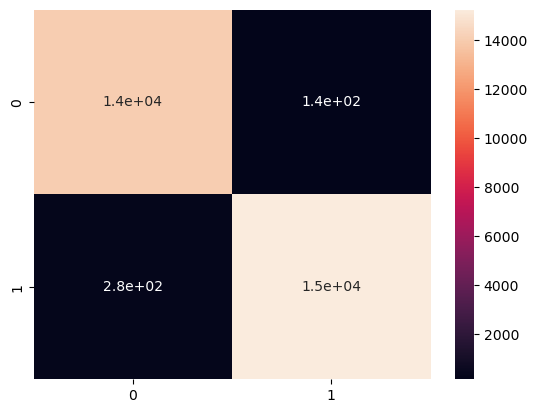

In [19]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [20]:
from keras.models import load_model
from pathlib import Path

model.save_weights("BigdatasetCNNwithLSTMPaper18ML150.h5")
print('done')

model.save('BigdatasetCNNwithLSTMPaper18ML150.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
loaded_model = tf.keras.models.load_model('BigdatasetCNNwithLSTMPaper18ML150.h5')
loaded_model.load_weights('BigdatasetCNNwithLSTMPaper18ML150.h5')

In [22]:
def clean_data(input_val):

    txts = tok.texts_to_sequences(input_val)
    input_val = sequence.pad_sequences(txts, maxlen=max_len)

    return input_val


def predict_sqli_attack():
    
    repeat=True
    
    space=''
    for i in range(20):
        space+= "-"

    print(space) 
    input_val=input("Please enter some data: ")
    print(space)

    
    if input_val== '0':
        repeat=False
    
    sample_texts_list = []
    sample_texts_list.append(input_val)
    txts = tok.texts_to_sequences(sample_texts_list)
    txts = sequence.pad_sequences(txts, maxlen=max_len)

    result=loaded_model.predict(txts)
    print(result)


    print(space)
    
    
    if repeat == True:
            if result > 0.5:
                 print("ALERT! This can be SQL injection")
            elif result <= 0.5:
                 print("It seems to be a benign")
            
            print(space)
        
            predict_sqli_attack()
            
    elif repeat == False:
        print( " Closing ")

In [23]:
predict_sqli_attack()

--------------------
Please enter some data: '
--------------------
1/1 [==============================] - 1s 880ms/step
[[0.05323219]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: ' '
--------------------
1/1 [==============================] - 0s 44ms/step
[[0.99564195]]
--------------------
ALERT! This can be SQL injection
--------------------
--------------------
Please enter some data: " "
--------------------
1/1 [==============================] - 0s 47ms/step
[[0.05323219]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: "
--------------------
1/1 [==============================] - 0s 47ms/step
[[0.05323219]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: //
--------------------
1/1 [==============================] - 0s 30ms/step
[[0.05323219]]
--------------------
It seems to be a benign
-